# Transformation-robust adversarial example via EoT
- **Purpose:** This notebook aims to craft an adversarial example that is robust to random transformation
- **Experiments:**
    - Targeted attack
    - Untargeted attack
- **Details:**
    - Victim model: LeNet
    - Dataset: MNIST
    - Original label: 8
    - Targeted label: 3
- **Conclusion:**
| Attack scheme | Success rate | Failure rate | Other |
|:-------------:|:------------:|:------------:|:-----:|
|   Targeted    |    0.967     |    0.033     | 0.000 |
|  Untargeted   |    1.        |       0.     |   0.  |
- **Author**: Zhanyuan(Sean) Zhang

In [1]:
#pip install opencv-python-headless

In [2]:
import os.path as osp
import pickle
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision
from datetime import datetime
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import PIL

from model_utils import*
from mymodelzoo import*
from transforms import*

from torchvision.transforms import transforms
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

GeForce GTX 1080 Ti


In [3]:
SEED = 888

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
ckp_out_root = './models/lenet'
trainset = torchvision.datasets.MNIST("/data/mnist", train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST("/data/mnist", train=False, transform=transforms.ToTensor())

In [5]:
# Train a model from stretch

#train_model(model, trainset, ckp_out_root, epochs=2, testset=testset, device=device, optimizer=optimizer)

# Or load a checkpoint
ckp_dir = osp.join(ckp_out_root, "checkpoint.pth.tar")
if osp.isfile(ckp_dir):
    ckp = torch.load(ckp_dir)
    print(f"=> Loading checkpoint from {ckp_dir}")
    ckp_epoch = ckp["epoch"]
    best_test_acc = ckp["best_acc"]
    model.load_state_dict(ckp["state_dict"])
    optimizer.load_state_dict(ckp["optimizer"])
    print(f"=> Loaded checkpoint '{ckp_dir}' (epoch {ckp_epoch})")
    print(f"=> Best test acc. {best_test_acc}%")
else:
    print(f"No checkpoint found in {ckp_dir}")

=> Loading checkpoint from ./models/lenet/checkpoint.pth.tar
=> Loaded checkpoint './models/lenet/checkpoint.pth.tar' (epoch 2)
=> Best test acc. 99.0%


In [6]:
with open('./benign_8.np', 'rb') as file:
    benign = pickle.load(file)

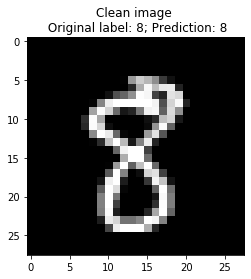

In [7]:
model.eval()
with torch.no_grad():
    logits = model(benign.to(device))
logits = logits.cpu().numpy()

ori_label = 8
plt.imshow(benign[0][0].numpy(), cmap='gray')
plt.title(f"Clean image \n Original label: {ori_label}; Prediction: {np.argmax(logits)}")
plt.show()

## 1. Define crafting function

In [8]:
def eot_craft(model: nn.Module, T: list, random_transform: RandomTransform, 
              adv_img: np.array, label: int, steps: int, step_size: float, targeted: bool, 
              eps_below: np.array, eps_above: np.array, 
              clip_below=0., clip_above=1., verbose=True, log_interval=100):
    
    def _craft_step(adv_img):
        average_loss, N = 0., len(T)
        for i, t in enumerate(T):
            x_t = torch.from_numpy(t(adv_img)).float().to(device)
            x_t.requires_grad_(True)
            logits = model(x_t)
            loss = criterion(logits, label)/N
            loss.backward()
            if targeted:
                adv_img -= step_size*np.sign(x_t.grad[0].cpu().numpy())
            else:
                adv_img += step_size*np.sign(x_t.grad[0].cpu().numpy())
            adv_img = np.clip(np.clip(adv_img, eps_below, eps_above), clip_below, clip_above)

            average_loss += loss.item()
        average_loss /= N
        return adv_img, average_loss
    
    label = torch.Tensor([label]).to(torch.int64).to(device)
    for step in range(1, steps+1):
        adv_img, average_loss = _craft_step(adv_img)
        if verbose and step % log_interval == 0:
            with torch.no_grad():
                x_t = random_transform(adv_img)
                logits = model(torch.from_numpy(x_t).float().to(device))
            logits = logits.cpu().numpy()
            pred = np.argmax(logits)
            plt.imshow(x_t[0][0], cmap="gray")
            plt.title(f"Step {step}: Prediction: {pred} \n Average_loss = {average_loss:.3f}")
            plt.show()
    return adv_img

def adv_eval(model, eval_steps, adv_img, targeted):
    fail_count = succ_count = 0
    other_count = 0 if targeted else None
    for _ in range(eval_steps):
        with torch.no_grad():
            x_t = random_transform(adv_img)
            logits = model(torch.from_numpy(x_t).float().to(device))
            logits = logits.cpu().numpy()
            pred = np.argmax(logits)
        if targeted:
            if pred == label:
                succ_count += 1
            elif pred == ori_label:
                fail_count += 1
            else:
                other_count += 1
        else:
            if pred != label:
                succ_count += 1
            else:
                fail_count += 1
    if other_count is not None:
        print(f"Success rate: {succ_count/eval_steps:.3f}; Failure rate: {fail_count/eval_steps:.3f}; Others: {other_count/eval_steps:.3f}")
    else:
        print(f"Success rate: {succ_count/eval_steps:.3f}; Failure rate: {fail_count/eval_steps:.3f}")

#### Define Transformation distribution T and RandomTransform

In [9]:
T = [get_random_gaussian(max_sigma=0.1),
     get_random_rotate(min_deg=-22.5, max_deg=22.5),
     get_random_contrast(min_alpha=0.5, max_alpha=1.5),
     get_random_brightness(min_beta=-0.05, max_beta=0.05),
     get_random_blur(min_blur_size=1, max_blur_size=5)]

random_transform = RandomTransform(T)

## 3.1 Experiments 1: Targeted attack

In [10]:
# Experiment params
eps = 60./225.
step_size = 1e-3
targeted = True
label = 3 # Targeted label
steps = 5000
ori_img = benign.numpy()
eps_below = ori_img - eps
eps_above = ori_img + eps
adv_img = ori_img.copy()

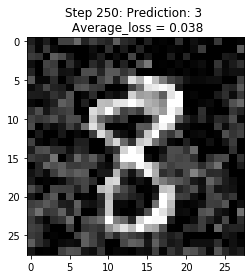

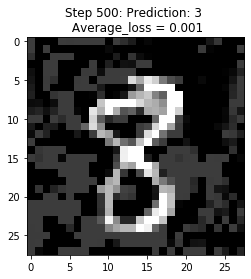

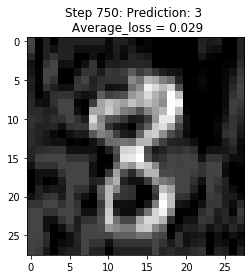

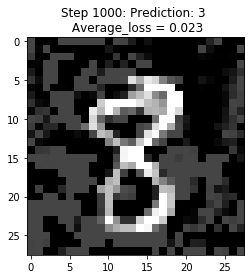

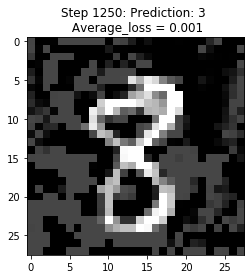

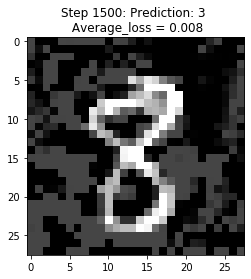

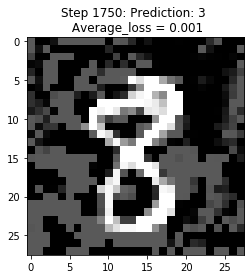

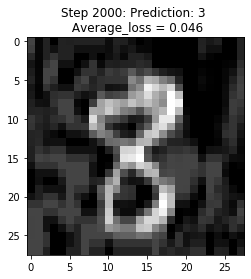

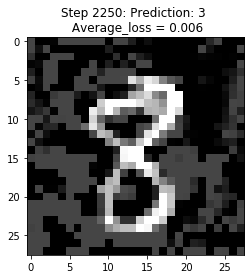

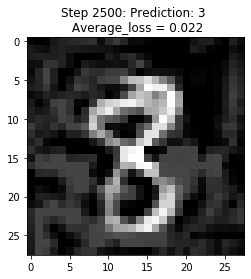

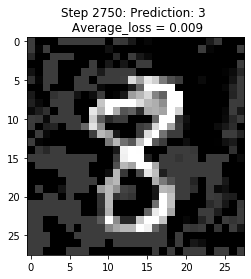

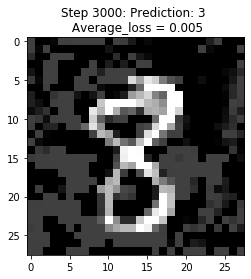

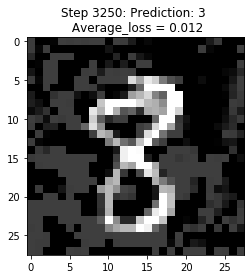

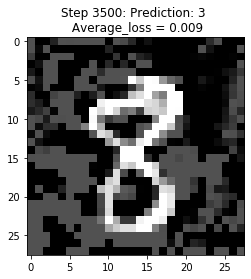

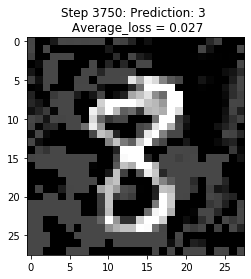

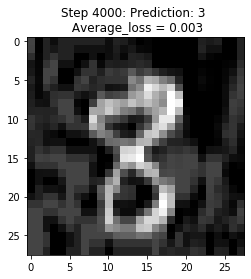

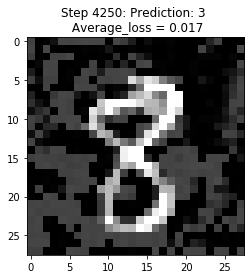

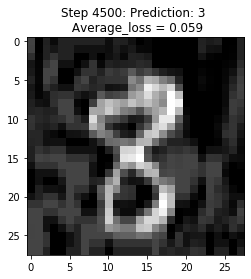

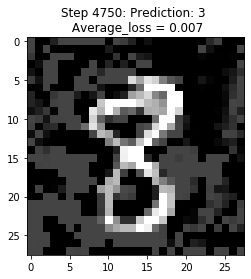

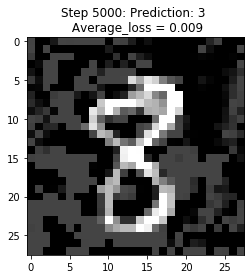

In [11]:
adv_img = eot_craft(model, T, random_transform, adv_img, label, steps, step_size, targeted, eps_below, eps_above, log_interval=250)

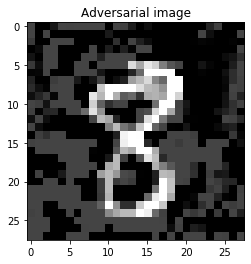

In [12]:
plt.imshow(adv_img[0][0], cmap='gray')
plt.title("Adversarial image")
plt.show()
with open("./adv_8_targeted.np", "wb") as file:
    pickle.dump(adv_img, file)

#### Evaluation: Targeted attack
- Success rate: % classified as the targeted label (3)
- Failure rate: % classified as the original label (8)
- Others: % clssified as other label

In [13]:
eval_steps = 5000
targeted = True
adv_eval(model, eval_steps, adv_img, targeted)

Success rate: 0.967; Failure rate: 0.033; Others: 0.000


## 3.2 Experiments 2: Untargeted attack

In [14]:
# Experiment params
eps = 60./225.
step_size = 1e-3
targeted = False
label = 8 # True label
steps = 5000
ori_img = benign.numpy()
eps_below = ori_img - eps
eps_above = ori_img + eps
adv_img = ori_img.copy()

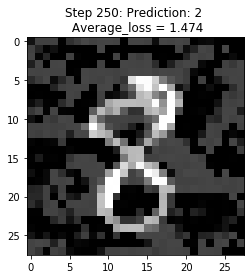

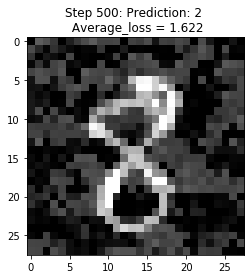

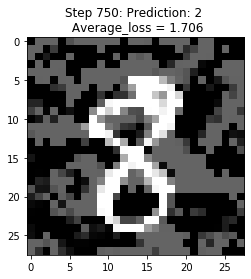

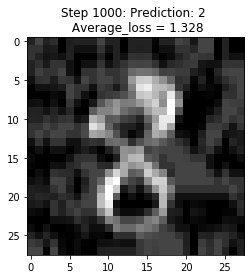

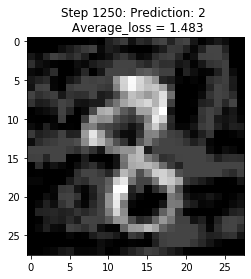

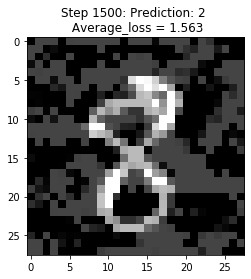

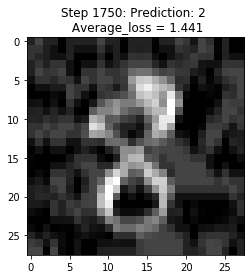

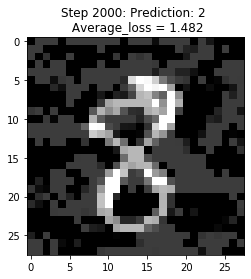

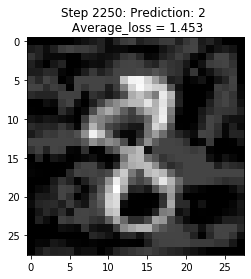

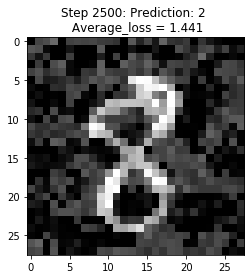

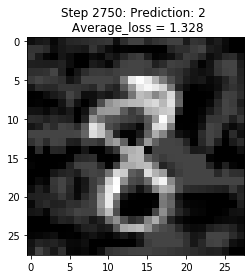

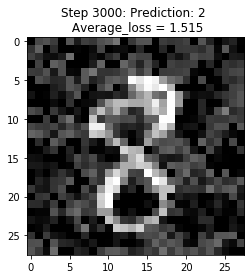

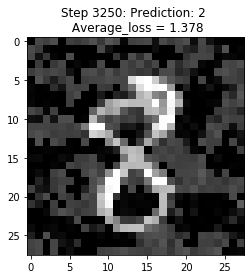

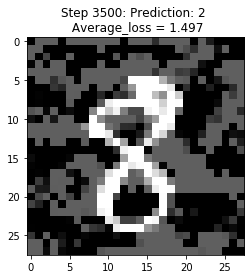

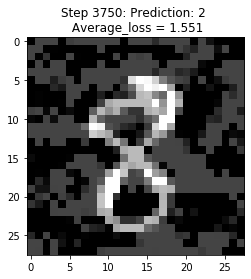

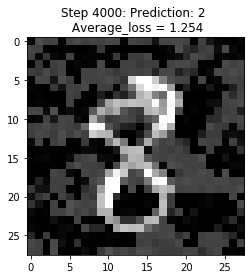

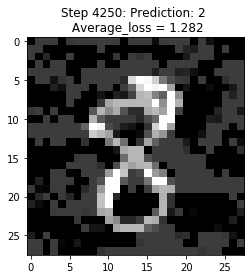

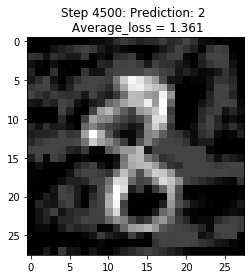

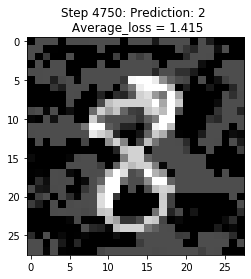

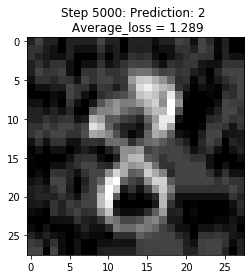

In [15]:
adv_img = eot_craft(model, T, random_transform, adv_img, label, steps, step_size, targeted, eps_below, eps_above, log_interval=250)

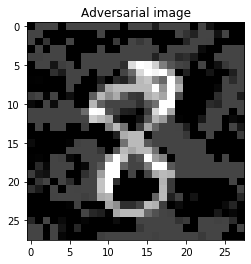

In [16]:
plt.imshow(adv_img[0][0], cmap='gray')
plt.title("Adversarial image")
plt.show()
with open("./adv_8_untargeted.np", "wb") as file:
    pickle.dump(adv_img, file)

#### Evaluation: Untargeted attack
- Success rate: % classified as the other label
- Failure rate: % classified as the original label (8)

In [17]:
eval_steps = 5000
targeted = False
adv_eval(model, eval_steps, adv_img, targeted)

Success rate: 1.000; Failure rate: 0.000
